# Fake news recognition using a Multinomial Naive Bayes Classifier

## Second part: Trump Dataset

### Course: Advanced Statistics for Physics Analysis
### Students: Toso Simone, Feltrin Antonio


In this notebook we apply the same procedure used on the first dataset. This new dataset presents longer documents which are classified as either 
 - Reliable {0}
 - Unreliable {1}

In [1]:
library(tidyverse)
library(stringr)
library(tm)             #Text-mining package
library(NLP) 
library(textstem)      #For lemmatization

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.2.0
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: NLP


Attaching package: ‘NLP’


The following object is masked from ‘package:ggplot2’:

    annotate


Loading required package: koRpus.lang.en

Loading required package: koRpus

Loading required package: sylly

For information on available language packages for 'koRpus', run

  available.koRpus.lang()

and see ?install.koRpus.lang()



Attaching package: ‘koRpus’


The following object is masked from ‘package:tm’:

    readTagged


The followin

## Dataset structure

    id: unique id for a news article
    title: the title of a news article
    author: author of the news article
    text: the text of the article; could be incomplete
    label: a label that marks the article as potentially unreliable
        1: unreliable
        0: reliable
 
 ## Read the data

In [2]:
dir_input <- 'data/trump/train.csv'
dir_test <- 'data/trump/test.csv'
input.df <- read.csv(dir_input,header=TRUE,sep=',')
test.df <- read.csv(dir_test,header=TRUE,sep=',')

In [4]:
notext <- input.df[, c(1,2,3,5)]

In [5]:
head(notext, 3)

,id,title,author,label
,<int>,<chr>,<chr>,<int>
1,0,House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It,Darrell Lucus,1
2,1,"FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart",Daniel J. Flynn,0
3,2,Why the Truth Might Get You Fired,Consortiumnews.com,1


## Preprocessing

In [6]:
#Removes punctuation, uppercase to lowercase
plain <- function(word,punct='[:punct:]'){
    word <- str_to_lower(str_replace_all(word,punct,' '))
    return(word) 
}

#Gets all unique words from the list of records
get.unique.words <- function (tags.bag,sep,sortit=FALSE) {
    all.tags <- c()
    for (record in tags.bag){
        temp.tags <- str_split_1(plain(record),sep)
        for (word in temp.tags) {
            word <- plain(word)
            if (word %in% all.tags == FALSE & word != '') {
                    all.tags <- c(all.tags,str_to_lower(word))
                } 
            }
        }
    if (sortit) {all.tags <- sort(all.tags)}
    return(all.tags)
}

#Removes all stopwords, punctuation etc. from the records
get.quotes <- function (quotes.bag,sep) {
    all.quotes <- list()
    for (record in quotes.bag){
        temp.q <- str_split_1(plain(record),sep)
        temp.q <- str_flatten(temp.q[!(temp.q %in% stopwords('en')) & str_length(temp.q)>1], collapse = ' ') #>1 to remove lone letters? no because of $
        all.quotes <- c(all.quotes,temp.q)
        }

    return(all.quotes)
}

#Get all unique tags (could be useful)
get.tags <- function (tags.bag,sep) {
    all.quotes <- list()
    for (record in tags.bag){
        #cat('\nrecord, type',record,typeof(record))
        temp.q <- str_split(plain(record,punct = '[.;()]'),sep)
        temp.q <- str_flatten(temp.q[[1]][!(temp.q %in% stopwords('en'))],  collapse = ' ') #>1 to remove lone letters? no because of $
        all.quotes <- c(all.quotes,temp.q)
        }

    return(all.quotes)
}

In [7]:
quotes <- get.quotes(input.df$title,sep=' ')

train.df <- data.frame(Labels = input.df$label, Text = unlist(quotes))

#### Lemmatization

In [8]:
train.df$Text <- lemmatize_strings(train.df$Text)

In [10]:
head(train.df, 12)

,Labels,Text
,<int>,<chr>
1,1,house dem aide didn even see comey letter jason chaffetz tweet
2,0,flynn hillary clinton big woman campus breitbart
3,1,truth may get fire
4,1,15 civilian kill single us airstrike identify
5,1,iranian woman jail fictional unpublished story woman stone death adultery
6,0,jackie mason hollywood love trump bomb north korea lack trans bathroom exclusive video breitbart
7,1,life life luxury elton john favorite shark picture stare long transcontinental flight
8,0,benoît hamon win french socialist party presidential nomination new york time
9,0,excerpt draft script donald trump ampa black church pastor new york time


#### Token normalization: 


In [11]:
train.df$Text <- str_replace_all(train.df$Text, regex("\\$[0-9]*"), "<MONEY>")
train.df$Text <- str_replace_all(train.df$Text, regex("(18|19|20)\\d{2}"), "<YEAR>")
train.df$Text <- str_replace_all(train.df$Text, regex("\\d+"), "<NUMBER>")

In [12]:
vocabulary <- get.unique.words(train.df$Text,sep=' ')

## Vocabulary building 

#### We take part of the dataset (e.g. the first 80% of the records) and construct our vocabulary, which will be used for training. 
#### The remaining 20% will serve for validation.

In [13]:
validation.df <- train.df[ceiling(0.8*nrow(train.df)):nrow(train.df),]
train.df <- train.df[1:ceiling(0.8*nrow(train.df)),]

### vocab.df, to store how many times each word appears

In [14]:
find.vocabulary <- function(N, unique=FALSE){
    vocabulary.df <- data.frame("Token" = vocabulary[1], "Class_0" = 0, "Class_1" = 0)
    for (i in 1:N){
        record <- train.df$Text[i]
        class <- train.df$Labels[i]
        temp.q <- str_split_1(plain(record), " ")
        if(unique){
            temp.q <- unique(temp.q)
        }
        
        for(word in temp.q){
            if(!(word %in% vocabulary.df$Token)){
                classes <- rep(0,2)
                classes[class + 1] <- 1
                vocabulary.df <- rbind(vocabulary.df, list(word, classes[1], classes[2] ))
            }
            else{
                #Trova dove sta la parola --> somma 1 al contatore della classe
                vocabulary.df[which(vocabulary.df$Token == word), class + 2] <- vocabulary.df[which(vocabulary.df$Token == word), class + 2] + 1
            }
        }
    }
    return(vocabulary.df)
}

In [15]:
n.records <- length(train.df$Text) #Number of records
vocab.df <- find.vocabulary(n.records)

### vocab.bool.df --> here we store in how many documents of each class the word appears

In [16]:
vocab.bool.df <- find.vocabulary(n.records, TRUE)

In [17]:
head(vocab.bool.df, 8)

,Token,Class_0,Class_1
,<chr>,<dbl>,<dbl>
1,house,178,72
2,dem,23,12
3,aide,20,19
4,didn,14,24
5,even,158,29
6,see,79,67
7,comey,62,77
8,letter,16,36


In [15]:
# Rimuovi le righe dove il token ha lunghezza di un carattere


## Mutual Information 
We evaluate the mutual information for each class (among the possibilities (class, not class)) and make an average.

$\sum_{\mathrm{class}\in\{0,1\}}\sum_{\mathrm{token}\in\{0,1\}}P(class, token) \log{\frac{P(class, token)}{P(class)P(token)}}$

In [18]:
NCs <- hist(train.df$Labels,breaks=seq(-1,1),plot=FALSE)$counts #Number of documents for each class

In [19]:
MIs <- rep(0, length(vocab.bool.df$Token))
cat(str(MIs))

#Evaluate MI separately for each class, then average
for(i in 1:length(vocab.df$Token)){
    MI <- 0
    N.t <- sum(vocab.bool.df[i, 2:3])
    N.not.t <- n.records - N.t
    for(class in 0:1){
        MI.c <- 0
        N.c <- NCs[class + 1]
        N.not.c <- n.records - N.c 
        N.ct <- vocab.bool.df[i, class + 2]
        
        class.index <- switch(class + 1, "Class_0", "Class_1")
        N.not.c.not.t <- n.records - sum(vocab.bool.df[i, 2:3]) + N.ct - sum(vocab.bool.df$class.index)
        
        
        #P(class, token)log(...) + P(nonclass, token) + P(class, non token) + P(non class, non token)
        term <- ifelse(N.ct > 0, N.ct/n.records*log(N.ct*n.records/(N.c*N.t)), 0) + 
                ifelse((N.t - N.ct) > 0, (N.t - N.ct)/n.records*log((N.t-N.ct)*n.records/(N.not.c*N.t)), 0)+
                ifelse((N.c - N.ct) > 0, (N.c - N.ct)/n.records*log((N.c - N.ct)*n.records/(N.c * (N.not.t))), 0) + 
                ifelse(N.not.c.not.t > 0, N.not.c.not.t/n.records * log(N.not.c.not.t*n.records / (N.not.c * N.not.t)), 0)
                
        MI <- MI + term
        
    }
    
    MIs[i] <- MI
}

 num [1:15498] 0 0 0 0 0 0 0 0 0 0 ...


In [20]:
vocab.df$MI <- MIs

In [21]:
vocab.df.order.MI <- vocab.df[order(vocab.df$MI, decreasing = TRUE), ]

In [22]:
vocab.df.order.MI <- vocab.df.order.MI[-which(vocab.df.order.MI$Token == ""), ]

### Training 

In [39]:
vocab.sizes <- 10^seq(from = 2, to = 4, by = 0.05)

In [40]:
length(vocab.df.order.MI$Token)

[1] 15497

In [41]:
#Returns accuracy of feature selection with *size* best features
validate <- function(size){
    vocab.short <- vocab.df.order.MI[1:size, ]
    
    #Prior
    p.c <- log(NCs / n.records)

    posteriors.df <- vocab.short

    for(class in 0:1){
        posteriors.df[, class + 2] <- log(posteriors.df[, class + 2] / sum(posteriors.df[, class + 2]))
    } 
    
    predictions <- rep(0, length(validation.df$Text))
    for(i in 1:length(validation.df$Text)){
        record <- validation.df$Text[i]
        words <- str_split_1(plain(record), " ") 
        posteriors <- rep(0, 2) #Posterior probabilities (we want to find the maximum)
        for(class in 0:1){
            #For each class evaluate posterior
            posterior <- p.c[class + 1]
            for(word in words){
                #Check if word in vocabulary
                if(word %in% posteriors.df$Token){
                    posterior <- posterior + posteriors.df[which(posteriors.df$Token == word) , class + 2]
                }
            }
            posteriors[class + 1] <- posterior
        }

        predictions[i] <- which.max(posteriors) - 1
    }
    
    return(sum(predictions == validation.df$Labels) / length(validation.df$Labels))
 
}


In [42]:
scores <- rep(0, length(vocab.sizes))
for(i in 1:length(vocab.sizes)){
    scores[i] <- validate(vocab.sizes[i])
}
scores.results <- data.frame(vocab.sizes, scores)

In [43]:
head(scores.results)

,vocab.sizes,scores
,<dbl>,<dbl>
1,100.0000,0.7724105
2,112.2018,0.7834655
3,125.8925,0.7887527
4,141.2538,0.7928383
5,158.4893,0.8002884
6,177.8279,0.8038933


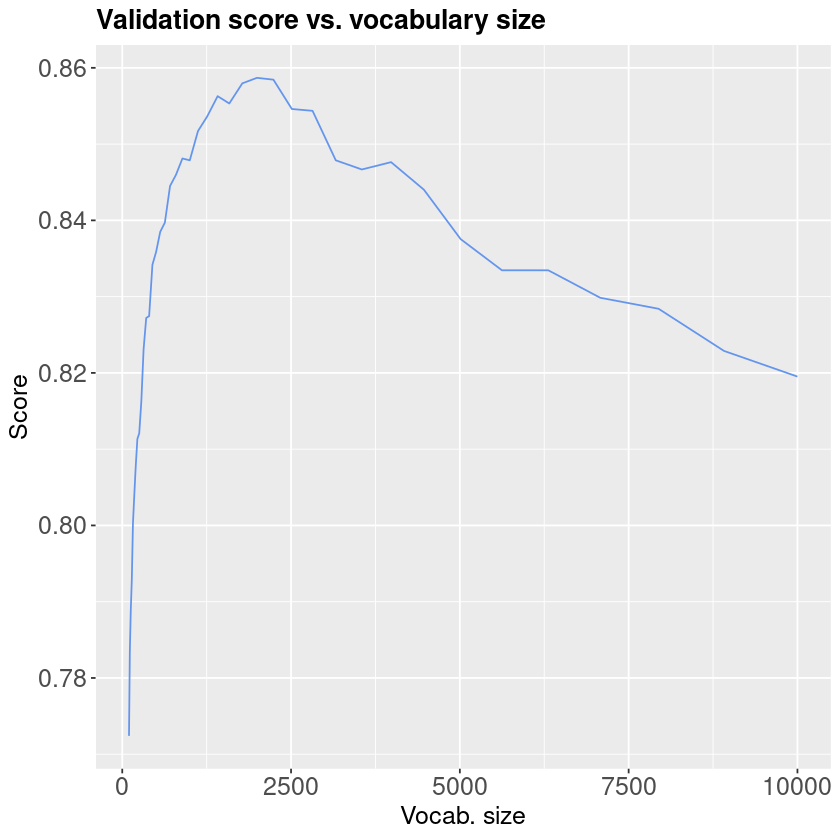

In [73]:
#Plot 
theme <- theme(legend.text = element_text(size = 12), axis.title = element_text(size = 15), axis.text = element_text(size = 15), plot.title = element_text(face = "bold", size = 16))
p <- ggplot(scores.results) + geom_line(aes(x = vocab.sizes, y = scores), col = "cornflowerblue")
labels <- labs(x = "Vocab. size", y = "Score")
title <- ggtitle("Validation score vs. vocabulary size")
p + labels + title + theme

In [76]:
scores.results[which.max(scores.results$scores), ]

,vocab.sizes,scores
,<dbl>,<dbl>
27,1995.262,0.8586878


### Confusion matrix

In [87]:
fit <- function(size, dataframe){
    vocab.short <- vocab.df.order.MI[1:size, ]
    
    #Prior
    p.c <- log(NCs / n.records)

    posteriors.df <- vocab.short

    for(class in 0:1){
        posteriors.df[, class + 2] <- log(posteriors.df[, class + 2] / sum(posteriors.df[, class + 2]))
    } 
    
    predictions <- rep(0, length(dataframe$Text))
    for(i in 1:length(dataframe$Text)){
        record <- dataframe$Text[i]
        words <- str_split_1(plain(record), " ") 
        posteriors <- rep(0, 2) #Posterior probabilities (we want to find the maximum)
        for(class in 0:1){
            #For each class evaluate posterior
            posterior <- p.c[class + 1]
            for(word in words){
                #Check if word in vocabulary
                if(word %in% posteriors.df$Token){
                    posterior <- posterior + posteriors.df[which(posteriors.df$Token == word) , class + 2]
                }
            }
            posteriors[class + 1] <- posterior
        }

        predictions[i] <- which.max(posteriors) - 1
    }
    
    return(predictions)
}

In [88]:
best.fit <- fit(1995, validation.df)
 
# Evaluate confusion matrix
confusion.matrix <- matrix(0, 2, 2)

for(i in 1:length(best.fit)){
    confusion.matrix[validation.df$Labels[i] + 1, best.fit[i] + 1] <- confusion.matrix[validation.df$Labels[i] + 1, best.fit[i] + 1] + 1
}

confusion.matrix <- data.frame(confusion.matrix)

#Normalize along rows
confusion.matrix <- confusion.matrix / apply(confusion.matrix, 1, sum)

#Set colnames
colnames(confusion.matrix) <- c("0", "1")
rownames(confusion.matrix) <- c("0", "1")

In [89]:
confusion.matrix

,0,1
,<dbl>,<dbl>
0,0.9189453,0.08105469
1,0.1997160,0.80028396


In [81]:
confusion.data.frame <- data.frame(row=character(0),col=character(0), confusion=numeric(0))
for(i in 1:length(rownames(confusion.matrix))){
    for(j in 1:length(colnames(confusion.matrix))){
        confusion.data.frame <- rbind(confusion.data.frame, list(rownames(confusion.matrix)[i],
                                                                colnames(confusion.matrix[j]), confusion.matrix[i,j]))
    }
}

colnames(confusion.data.frame) <- c("row", "col", "confusion")

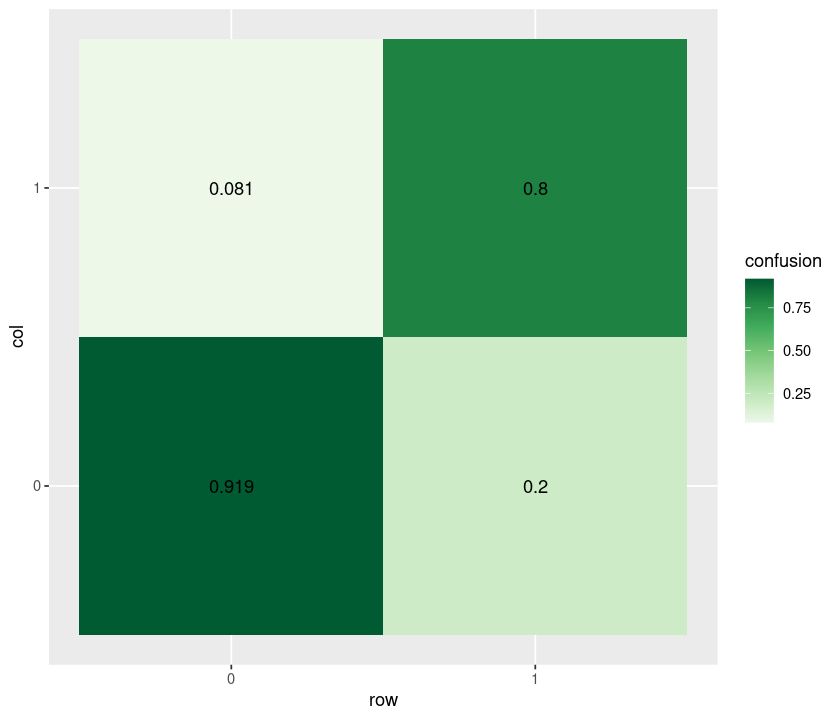

In [82]:
options(repr.plot.width=7, repr.plot.height=6)
ggp <- ggplot(confusion.data.frame, aes(row, col)) +    # Create default ggplot2 heatmap
  geom_tile(aes(fill = confusion))  + scale_fill_distiller(palette = "Greens", direction = +1)

ggp +                                         # Add values to heatmap
  geom_text(aes(label = round(confusion, digits = 3)))


## Test set

Finally, we predict the labels for the test set and check our score on Kaggle.

In [94]:
str(test.df)

'data.frame':	5200 obs. of  4 variables:
 $ id    : int  20800 20801 20802 20803 20804 20805 20806 20807 20808 20809 ...
 $ title : chr  "Specter of Trump Loosens Tongues, if Not Purse Strings, in Silicon Valley - The New York Times" "Russian warships ready to strike terrorists near Aleppo" "#NoDAPL: Native American Leaders Vow to Stay All Winter, File Lawsuit Against Police" "Tim Tebow Will Attempt Another Comeback, This Time in Baseball - The New York Times" ...
 $ author: chr  "David Streitfeld" "nan" "Common Dreams" "Daniel Victor" ...
 $ text  : chr  "PALO ALTO, Calif.  —   After years of scorning the political process, Silicon Valley has leapt into the fray. T"| __truncated__ "Russian warships ready to strike terrorists near Aleppo 08.11.2016 | Source: Source: Mil.ru Attack aircraft of "| __truncated__ "Videos #NoDAPL: Native American Leaders Vow to Stay All Winter, File Lawsuit Against Police Amnesty Internation"| __truncated__ "If at first you don’t succeed, try a different spo

In [96]:
quotes <- get.quotes(test.df$title,sep=' ')

test.df <- data.frame(Text = unlist(quotes), ID = test.df$id)

test.df$Text <- lemmatize_strings(test.df$Text)

test.df$Text <- str_replace_all(test.df$Text, regex("\\$[0-9]*"), "<MONEY>")
test.df$Text <- str_replace_all(test.df$Text, regex("(18|19|20)\\d{2}"), "<YEAR>")
test.df$Text <- str_replace_all(test.df$Text, regex("\\d+"), "<NUMBER>")

In [97]:
head(test.df, 3)

,Text,ID
,<chr>,<int>
1,specter trump loosen tongue purse string silicon valley new york time,20800
2,russian warship ready strike terrorist near aleppo,20801
3,nodapl native american leader vow stay winter file lawsuit police,20802


In [98]:
predictions.test <- fit(1995, test.df)

In [100]:
submit.df <- data.frame(id = test.df$ID, label = predictions.test)

In [104]:
head(submit.df, 10)

,id,label
,<int>,<dbl>
1,20800,0
2,20801,1
3,20802,0
4,20803,0
5,20804,1
6,20805,1
7,20806,0
8,20807,0
9,20808,1


In [103]:
write.csv(submit.df, "data//trump//submit.csv", row.names=FALSE)